In [98]:
import gc  
from pathlib import Path
import time
import json
import re
import random
import pickle
from itertools import combinations  

import joblib  
import lightgbm as lgb  
print(lgb.__version__)
import catboost as ctb
import numpy as np  
import pandas as pd  
from sklearn.metrics import mean_absolute_error 
import polars as pl
from numba import njit, prange
from typing import List, Mapping, Any

import warnings
from warnings import simplefilter 
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("ticks")

%load_ext autoreload
%autoreload 2

4.1.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
#==============================================================================

class CFG: 
    USE_LGB = True
    USE_NN = False
    IS_TRAIN = True
    IS_INFER = False
    LOCAL = True
    PLOT = True
    INFER_CACHE = 52
    RANDOM_STATE = 1847
    TEST_SIZE = 45
    N_FOLDS = 5
    POWER = 0.5
    USE_GPU = True
    N_JOBS = 3
    TRAIN_PATH = Path(".", "train_files", "train.csv")
    TEST_PATH = Path(".", "train_files", "train.csv")
    METADATA_PATH = Path(".", "job_artifacts", "optiver-cluster_and_weights-0004", "output_metadata.json")
    INPUT_MODELS_PATH = Path(".", "models")
    OUTPUT_MODELS_PATH = Path(".", "models")
    
#==============================================================================

In [100]:
def lgbm_params():
    """Returns algorithm parameters."""

    params = {
        "device"            : "gpu" if CFG.USE_GPU else "cpu",
        "objective"         : "mae",
        "max_depth"         : 11,
        "num_leaves"        : 256,
        "n_estimators"      : 6000,
        "subsample"         : 0.6,
        "colsample_bytree"  : 0.8,
        "reg_alpha"         : 0.2,
        "reg_lambda"        : 3.25,
        "learning_rate"     : 0.01,
        "importance_type"   : "gain",
        "random_state"      : CFG.RANDOM_STATE,
        "n_jobs"            : CFG.N_JOBS,
        "verbose"           : -1
    }

    return params


def lgbm_callbacks():
    """Returns algorithm callbacks"""
    return  [lgb.early_stopping(100), lgb.log_evaluation(100)]


MODEL_CFG = {
    lgb.LGBMRegressor.__name__ : {
        "params_func": lgbm_params,
        "callbacks": lgbm_callbacks
    }
}

## **Utilities**
---------------

In [101]:
#==============================================================================

class PurgedEmbargoSplit(object):

    def __init__(
        self,
        n_splits: int = 5,
        *args,
        **kwargs
    ) -> None:
    
        self.n_splits = n_splits


    def split(
        self,
        date_id,
        *args, 
        **kwargs
    ):

        fold_size = date_id.unique().shape[0] // self.n_splits

        for i in range(self.n_splits):
            start = i * fold_size
            end = start + fold_size

            # Define the purged set ranges
            purged_before_start = start - 2
            purged_before_end = start + 2
            purged_after_start = end - 2
            purged_after_end = end + 2

            # Exclude the purged ranges from the test set
            purged_set = ((date_id >= purged_before_start) & (date_id <= purged_before_end)) | \
                         ((date_id >= purged_after_start) & (date_id <= purged_after_end))

            # Define test_indices excluding the purged set
            test_indices = (date_id >= start) & (date_id < end) & ~purged_set
            train_indices = ~test_indices & ~purged_set
            
            train_indices = train_indices[train_indices].index
            test_indices = test_indices[test_indices].index

            yield train_indices, test_indices


#==============================================================================


class PurgedEmbargoSplit2(object):

    def __init__(
        self,
        n_splits: int = 5,
        gap = 5,
        *args,
        **kwargs
    ) -> None:
    
        self.n_splits = n_splits
        self._gap = gap


    def split(
        self,
        date_id,
        *args, 
        **kwargs
    ):

        fold_size = date_id.unique().shape[0] // self.n_splits

        for i in range(self.n_splits):
            i = self.n_splits - 1
            start = i * fold_size
            end = start + fold_size
            if i < self.n_splits - 1:  # No need to purge after the last fold
                purged_start = end - 2
                purged_end = end + self._gap + 2
                train_indices = (date_id >= start) & (date_id < purged_start) | (date_id > purged_end)
            else:
                train_indices = (date_id >= start) & (date_id < end)
            
            test_indices = (date_id >= end) & (date_id < end + fold_size)

            train_indices = train_indices.index[train_indices]
            test_indices = test_indices.index[test_indices]

            yield train_indices, test_indices

#==============================================================================

In [102]:
#==============================================================================

class TrainTestSplit(object):

    def __init__(
        self,
        test_size: int,
        by_date_mode: bool = True,
        n_splits: int = 1,
        *args,
        **kwargs
    ):
    
        self._test_size = test_size
        self.n_splits = n_splits

        self._by_date_mode = by_date_mode


    def split(
        self,
        date_id,
        *args, 
        **kwargs
    ):

        n_samples = date_id.shape[0]

        if self._by_date_mode:
            n_train = date_id.loc[date_id <= date_id.max() - self._test_size].shape[0]
        else:
            n_train = n_samples - int(self._test_size * n_samples)

        n_test = n_samples - n_train

        train = np.arange(n_train)
        test = np.arange(n_train, n_train + n_test)
    
        for _ in range(self.n_splits):
            yield train, test 


In [103]:

#==============================================================================

def read_json(
    file: Path
) -> Mapping[str, Any]:
    """
    This function reads a json file.
    """

    with open(file, "r") as f:
        content = f.read()
        content = re.sub("//.*", "", content, flags=re.MULTILINE)
        content = json.loads(content)

    return content

#==============================================================================

def dump_json(
    file: Path,
    content: Mapping[str, Any],
    indent: int = None
) -> None:
    """
    This function dumps the dictionary to file.
    """

    with open(file, "w") as f:
        json.dump(content, f, indent=indent)


#==============================================================================

def save_model(
        model: Any,
        file: Path
    ) -> None:
    """Saves the model to disk in {name}.txt and {name}.pkl format"""

    try:
        model.booster_.save_model(str(file.with_suffix(".txt"))) # type lgb.basic.Booster
    except:
        pass

    # Save the model with pickle
    with open(file.with_suffix(".pkl"), "wb") as f:
        pickle.dump(model, f)


#==============================================================================

def load_model(
    model_type,
    booster_file
):
    model = model_type(model_file=str(booster_file.with_suffix(".txt")))
    
    return model


#==============================================================================

In [104]:
#==============================================================================

@njit
def power_decay_weights(n):
    w = []
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return w


#==============================================================================

@njit
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

#==============================================================================

@njit
def zero_mean(prices):
    prices -= prices.mean()
    return prices

#==============================================================================

@njit
def pow_order(x,n):
    if x >= 0:
        return x**(n)
    elif x < 0:
        return -(abs(x)**(n))

#==============================================================================

def pow_mean(array_results, order=0):
    array_results = array_results.copy()
    columns = [i for i in range(len(array_results))]
    df_results = pd.DataFrame(np.vstack(array_results).T)

    df_results.columns = columns.copy()
    pow_cols = []
    for col in columns:
        df_results[f"{col}_{order}"] = df_results[col].apply(lambda x: pow_order(x, order))
        pow_cols.append(f"{col}_{order}")
        
    return df_results[pow_cols].mean(axis=1).apply(lambda x: pow_order(x, 1./order)).values

#==============================================================================

def cross_validate(
        model_type, 
        model_params, 
        x, 
        y, 
        date_id=None, 
        cv=TrainTestSplit(45), 
        scorer=mean_absolute_error, 
        groups=None, 
        job_path=None, 
        power=None,
        callbacks_func=None,
        *args, 
        **kwargs
    ):

    scores = np.zeros(cv.n_splits)
    #seed = model_params.get("random_seed", 1020)
    #random.seed(seed)

    models = []
    print(f"Starting evaluation...")
    print("=" * 30)

    y_preds = []
    for i, (train_index, val_index) in enumerate(cv.split(date_id=date_id, groups=groups)):

        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if "sample_weight" in kwargs.keys():
            kwargs["sample_weight"] = kwargs["sample_weight"][train_index]

        model = model_type(**model_params)
        #random_state = random.randint(1, 9999)
        #model.set_params(random_state=random_state)

        #print(f"Training model with seed {random_state}")

        eval_set = None
        if x_val.shape[0] > 0:
            eval_set = [(x_val, y_val)]

        callbacks = callbacks_func()
        start = time.time()
        model.fit(x_train, y_train, eval_set=eval_set, callbacks=callbacks, *args, **kwargs)
        end = time.time()
        
        models.append(model)

        if eval_set is not None:
            y_pred = model.predict(x_val)
            scores[i] = scorer(y_pred, y_val)
            y_preds.append(y_pred)

            print(f"Fold {i + 1}: {scores[i]:.4f} (took {end - start:.2f}s)")

        if job_path is not None:
            model_path = job_path.joinpath("models")
            model_path.mkdir(exist_ok=True, parents=True)
            save_model(model, file=model_path.joinpath("model-" + str(i + 1).zfill(2) + ".pkl"))
        
        gc.collect()

    print("-" * 30)
    print(f"Average MAE = {scores.mean():.4f} ± {scores.std():.4f}")
    if power is not None:
        y_pred = pow_mean(y_preds, power)
        score = scorer(y_pred, y_val)
        print(f"Ensembling MAE = {score:.4f}")
    print("=" * 30)
    
    return scores, models

#==============================================================================

In [105]:
#==============================================================================

def downcast(df: pd.DataFrame, verbose: int = 0):
    '''This function downcasts the elements in a dataframe to reduce the memory footprint'''

    start_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")

    fcols = df.select_dtypes("float").columns
    icols = df.select_dtypes("integer").columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast="float")
    df[icols] = df[icols].apply(pd.to_numeric, downcast="integer")

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print(f"Decreased by {decrease:.2f}%")
        
#==============================================================================


def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")
    return df

#==============================================================================



 ## **Feature Engineering**
 ----------------------------

In [106]:
#==============================================================================

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

#==============================================================================

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

#==============================================================================

@njit
def moving_avg(arr: np.ndarray, window: int, min_periods: int = 1) -> np.ndarray:
    result = np.full(arr.shape, np.nan)  # Fill with nan
    if min_periods is None:
        min_periods = window

    for i in range(arr.shape[0]):
        windowed_data = arr[max(0, i - window + 1) : i + 1]
        valid_count = np.sum(~np.isnan(windowed_data))
        if valid_count >= min_periods:
            result[i] = np.nanmean(windowed_data)  # Compute mean considering possible NaN values

    return result

#==============================================================================

def get_moving_avg(x, lookback=10):
    x = x.to_numpy()
    return moving_avg(x, lookback)

#==============================================================================

@njit
def weighted_avg(values: np.ndarray, weights: np.ndarray):
    """
    Return the weighted average.

    values, weights -- NumPy ndarrays with the same shape.
    """
    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    return np.average(masked_values, weights=masked_weights)


#==============================================================================

def get_weighted_avg(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_avg(values, weights)

#==============================================================================

@njit
def weighted_std(values, weights):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """

    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    average = np.average(masked_values, weights=masked_weights)

    # Fast and numerically precise:
    variance = np.average((masked_values - average)**2, weights=masked_weights)
    return np.sqrt(variance)

#==============================================================================

def get_weighted_std(x: pd.Series):

    weights = x["stock_weights"].to_numpy().ravel()
    values = x.drop(columns=["stock_weights"]).to_numpy().ravel()

    return weighted_std(values, weights)


#==============================================================================

def get_macd(df, signal=9, fast=12, slow=26):

    macd = df.ewm(span=fast, adjust=False, min_periods=fast).mean() - \
           df.ewm(span=slow, adjust=False, min_periods=slow).mean()
    
    macd_signal = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    macd_diff = macd - macd_signal
    
    return pd.DataFrame({"macd": macd, "macd_signal": macd_signal, "macd_diff": macd_diff})

#==============================================================================

def get_bollinger_bands(
    series, window: int = 20, *, num_stds: tuple[float, ...] = (2, 0, -2), 
        prefix: str = 'bollinger') -> pd.DataFrame:
    rolling = series.rolling(window)
    bband0 = rolling.mean()
    bband_std = rolling.std(ddof=0)
    return pd.DataFrame({f'{prefix}.{num_std}': (bband0 + (bband_std * num_std)) for num_std in num_stds})

#==============================================================================

@njit
def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)

    if a.size > n:
        a[n] = np.nanmean(x[1:n+1])
        for i in range(n+1, len(x)):
            a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

#==============================================================================

def get_rsi(df, window):
    change = df.diff()
    gain = change.mask(change < 0, 0.)
    loss = -change.mask(change > 0, -0.)

    avg_gain = rma(gain.to_numpy(), window)
    avg_loss = rma(loss.to_numpy(), window)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return pd.Series(rsi, index=df.index) 

#==============================================================================

In [107]:
#==============================================================================

def feature_engineering(df, weights, clusters, global_aggr):
    
    ###########################################
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    ###########################################
    
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df["ask_size"] + df["bid_size"]
    df["mid_price"] = (df["ask_price"] + df["bid_price"]) / 2.
    df["liquidity_imbalance"] = (df["bid_size"] - df["ask_size"])/(df["bid_size"] + df["ask_size"])
    df["matched_imbalance"] = (df["imbalance_size"] - df["matched_size"])/(df["matched_size"] + df["imbalance_size"])
    df["size_imbalance"] = df["bid_size"] / df["ask_size"]

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    for c in [["ask_price", "bid_price", "wap", "reference_price"], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    group_stock = df.groupby("stock_id") 
    
    #df["stock_clusters"] = df["stock_id"].map(clusters)
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = group_stock["weighted_wap"].pct_change(periods=6)
   
    df["imbalance_momentum"] = group_stock['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = group_stock["price_spread"].diff()
    df['price_pressure'] = df['imbalance_size'] * (df["ask_price"] - df["bid_price"])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df["micro_price"] = ((df["bid_price"] * df["ask_size"]) + (df["ask_price"] * df["bid_size"])) / (df["bid_size"] + df["ask_size"])
    df["relative_spread"] = (df['ask_price'] - df['bid_price']) / df['wap']

    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    for col in ["matched_size", "imbalance_size", "reference_price", "imbalance_buy_sell_flag"]:
        for window in [1, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = group_stock[col].shift(window)
            df[f"{col}_ret_{window}"] = group_stock[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ["ask_price", "bid_price", "ask_size", "bid_size", "weighted_wap", "price_spread"]:
        for window in [1, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = group_stock[col].diff(window)
    
    #V4 feature
    for window in [3, 5, 10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    #Define the windows and columns for which you want to calculate the rolling statistics
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']
    # Loop over each window and column to create the rolling mean and std expressions
    for window in [3, 5, 10]:
        for col in columns:
            rolling_mean = group_stock[f"{col}_diff_{window}"].rolling(window).mean()
            df[f"rolling_diff_{col}_{window}"] = rolling_mean.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
            rolling_std = group_stock[f"{col}_diff_{window}"].rolling(window).std()
            df[f"rolling_std_diff_{col}_{window}"] = rolling_std.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])

    gc.collect()

    prices = ["wap", "ask_price", "bid_price", "reference_price"]
    """
    # RSI (momentum indicator)
    for col in prices:
        rsi = group_stock[col].apply(lambda x: get_rsi(x, 14))
        df[f"{col}_rsi_14"] = rsi.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
    """

    # MACD (trend indicator)
    for col in prices:
        macd = group_stock[col].apply(lambda x: get_macd(x, 9, 12, 26))
        macd = macd.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
        for inner_col in macd.columns:
            df[f"{col}_{inner_col}_9_12_26"] = macd[inner_col]

    # Bollinger (volatility indicator)
    for col in prices:
        bollinger = group_stock[col].apply(lambda x: get_bollinger_bands(x, 20, num_stds=(-2, 0, 2)))
        bollinger = bollinger.reset_index().drop(columns=["stock_id"]).set_index(["level_1"])
        for inner_col in bollinger.columns:
            df[f"{col}_{inner_col}_20"] = bollinger[inner_col]
    
    df["mid_price_per_volume"] = df["mid_price_movement"] * df["volume"]
    df["harmonic_imbalance"] = 2 / ((1 / df["bid_size"]) + (1 / df["ask_size"]))
    
    # Time features
    df["day_of_week"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60
    df["seconds_to_market_close"] = 540 - df["seconds_in_bucket"]
    
    # Global features
    for key, value in global_aggr.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    # Clean infinite values
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)
        
    gc.collect()

    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    return df[feature_name]

#==============================================================================

In [108]:
df = pd.read_csv(CFG.TRAIN_PATH)
df = df.dropna(subset=["target"])
df.reset_index(drop=True, inplace=True)

metadata = read_json(CFG.METADATA_PATH)
stock_weights = {int(k): v for k, v in metadata["stock_weights"].items()}
stock_clusters = {int(k): v for k, v in metadata["stock_clusters"].items()}
date_ids = df["date_id"]

print(df.dtypes)

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object


In [109]:
sample_group = df.groupby("stock_id")
global_aggr = {
    "median_size": sample_group["bid_size"].median() + sample_group["ask_size"].median(),
    "std_size": sample_group["bid_size"].std() + sample_group["ask_size"].std(),
    "ptp_size": sample_group["bid_size"].max() - sample_group["bid_size"].min(),
    "median_price": sample_group["bid_price"].median() + sample_group["ask_price"].median(),
    "std_price": sample_group["bid_price"].std() + sample_group["ask_price"].std(),
    "ptp_price": sample_group["bid_price"].max() - sample_group["ask_price"].min(),
}

if CFG.IS_TRAIN:
    print("=" * 50)
    print("Performing data engineering...")
    print("-" * 30)
    df_feats = df.copy()
    df_feats = feature_engineering(df_feats, stock_weights, stock_clusters, global_aggr)
    print("Optimizing memory usage...")
    print("-" * 30)
    df_feats = reduce_mem_usage(df_feats)
    print("Data engineering done!")
    print("-" * 30)
    print(f"Number of features is {df_feats.shape[-1]}")
    print("=" * 50)

Performing data engineering...
------------------------------
Optimizing memory usage...
------------------------------
Data engineering done!
------------------------------
Number of features is 184


## **Cross-validation and Training**
-----------------------

### **LGBM**
------------

In [110]:
if CFG.USE_LGB and CFG.IS_TRAIN:
    
    print("=" * 50)
    print("Starting with LGBM models...")
    print("-" * 30)
    model_cls = lgb.LGBMRegressor
    model_cfg = MODEL_CFG[model_cls.__name__]
    param_space_func = model_cfg["params_func"]
    callbacks_func = model_cfg["callbacks"]
    model_params = param_space_func()

    # Crossvalidate with Purged Embargo method and early stopping
    _, trained_models = cross_validate(
        model_type=model_cls,
        model_params=model_params,
        x=df_feats,
        y=df["target"],
        date_id=date_ids,
        scorer=mean_absolute_error,
        cv=PurgedEmbargoSplit(n_splits=CFG.N_FOLDS),
        callbacks_func=callbacks_func
    )

    print("=" * 50)
    print("Training final model...")
    print("-" * 30)

    # Get mean number of iterations and train another model with full dataset
    model_params = param_space_func()
    model_params["n_estimators"] = int(1.2 * np.mean([model.best_iteration_ for model in trained_models]))

    _, final_model = cross_validate(
        model_type=model_cls,
        model_params=model_params,
        x=df_feats,
        y=df["target"],
        date_id=date_ids,
        scorer=mean_absolute_error,
        cv=TrainTestSplit(test_size=0, n_splits=1),
        callbacks_func=(lambda: [lgb.log_evaluation(100)])
    )
    trained_models += final_model

    filename = CFG.OUTPUT_MODELS_PATH.joinpath("lgbm_models")
    filename.mkdir(exist_ok=True, parents=True)
    for i, model in enumerate(trained_models):
        model.booster_.save_model(str(filename.joinpath("model_" + str(i).zfill(2) + ".txt")))

    print("Training done!")
    print("=" * 50)

Starting with LGBM models...
------------------------------
Starting evaluation...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 5.60062
[200]	valid_0's l1: 5.57368
[300]	valid_0's l1: 5.56158
[400]	valid_0's l1: 5.5542
[500]	valid_0's l1: 5.54997
[600]	valid_0's l1: 5.54654
[700]	valid_0's l1: 5.54381
[800]	valid_0's l1: 5.54218
[900]	valid_0's l1: 5.54091
[1000]	valid_0's l1: 5.54034
[1100]	valid_0's l1: 5.53988
[1200]	valid_0's l1: 5.53945
[1300]	valid_0's l1: 5.53911
[1400]	valid_0's l1: 5.53881
[1500]	valid_0's l1: 5.53857
[1600]	valid_0's l1: 5.5384
[1700]	valid_0's l1: 5.5383
[1800]	valid_0's l1: 5.5382
[1900]	valid_0's l1: 5.53808
[2000]	valid_0's l1: 5.53788
[2100]	valid_0's l1: 5.53768
[2200]	valid_0's l1: 5.53755
[2300]	valid_0's l1: 5.53745
[2400]	valid_0's l1: 5.53724
[2500]	valid_0's l1: 5.5371
[2600]	valid_0's l1: 5.53701
[2700]	valid_0's l1: 5.53702
[2800]	valid_0's l1: 5.53697
[2900]	valid_0's l1: 5.53686
[3000]	valid_0's l1: 5.53686

In [111]:
if (CFG.IS_TRAIN or CFG.IS_INFER):
    lgbm_models = []
    if CFG.USE_LGB:
        models_boosters = CFG.INPUT_MODELS_PATH.joinpath("lgbm_models").glob("**/*.txt")
        lgbm_models = [load_model(lgb.Booster, path) for path in sorted(models_boosters)]

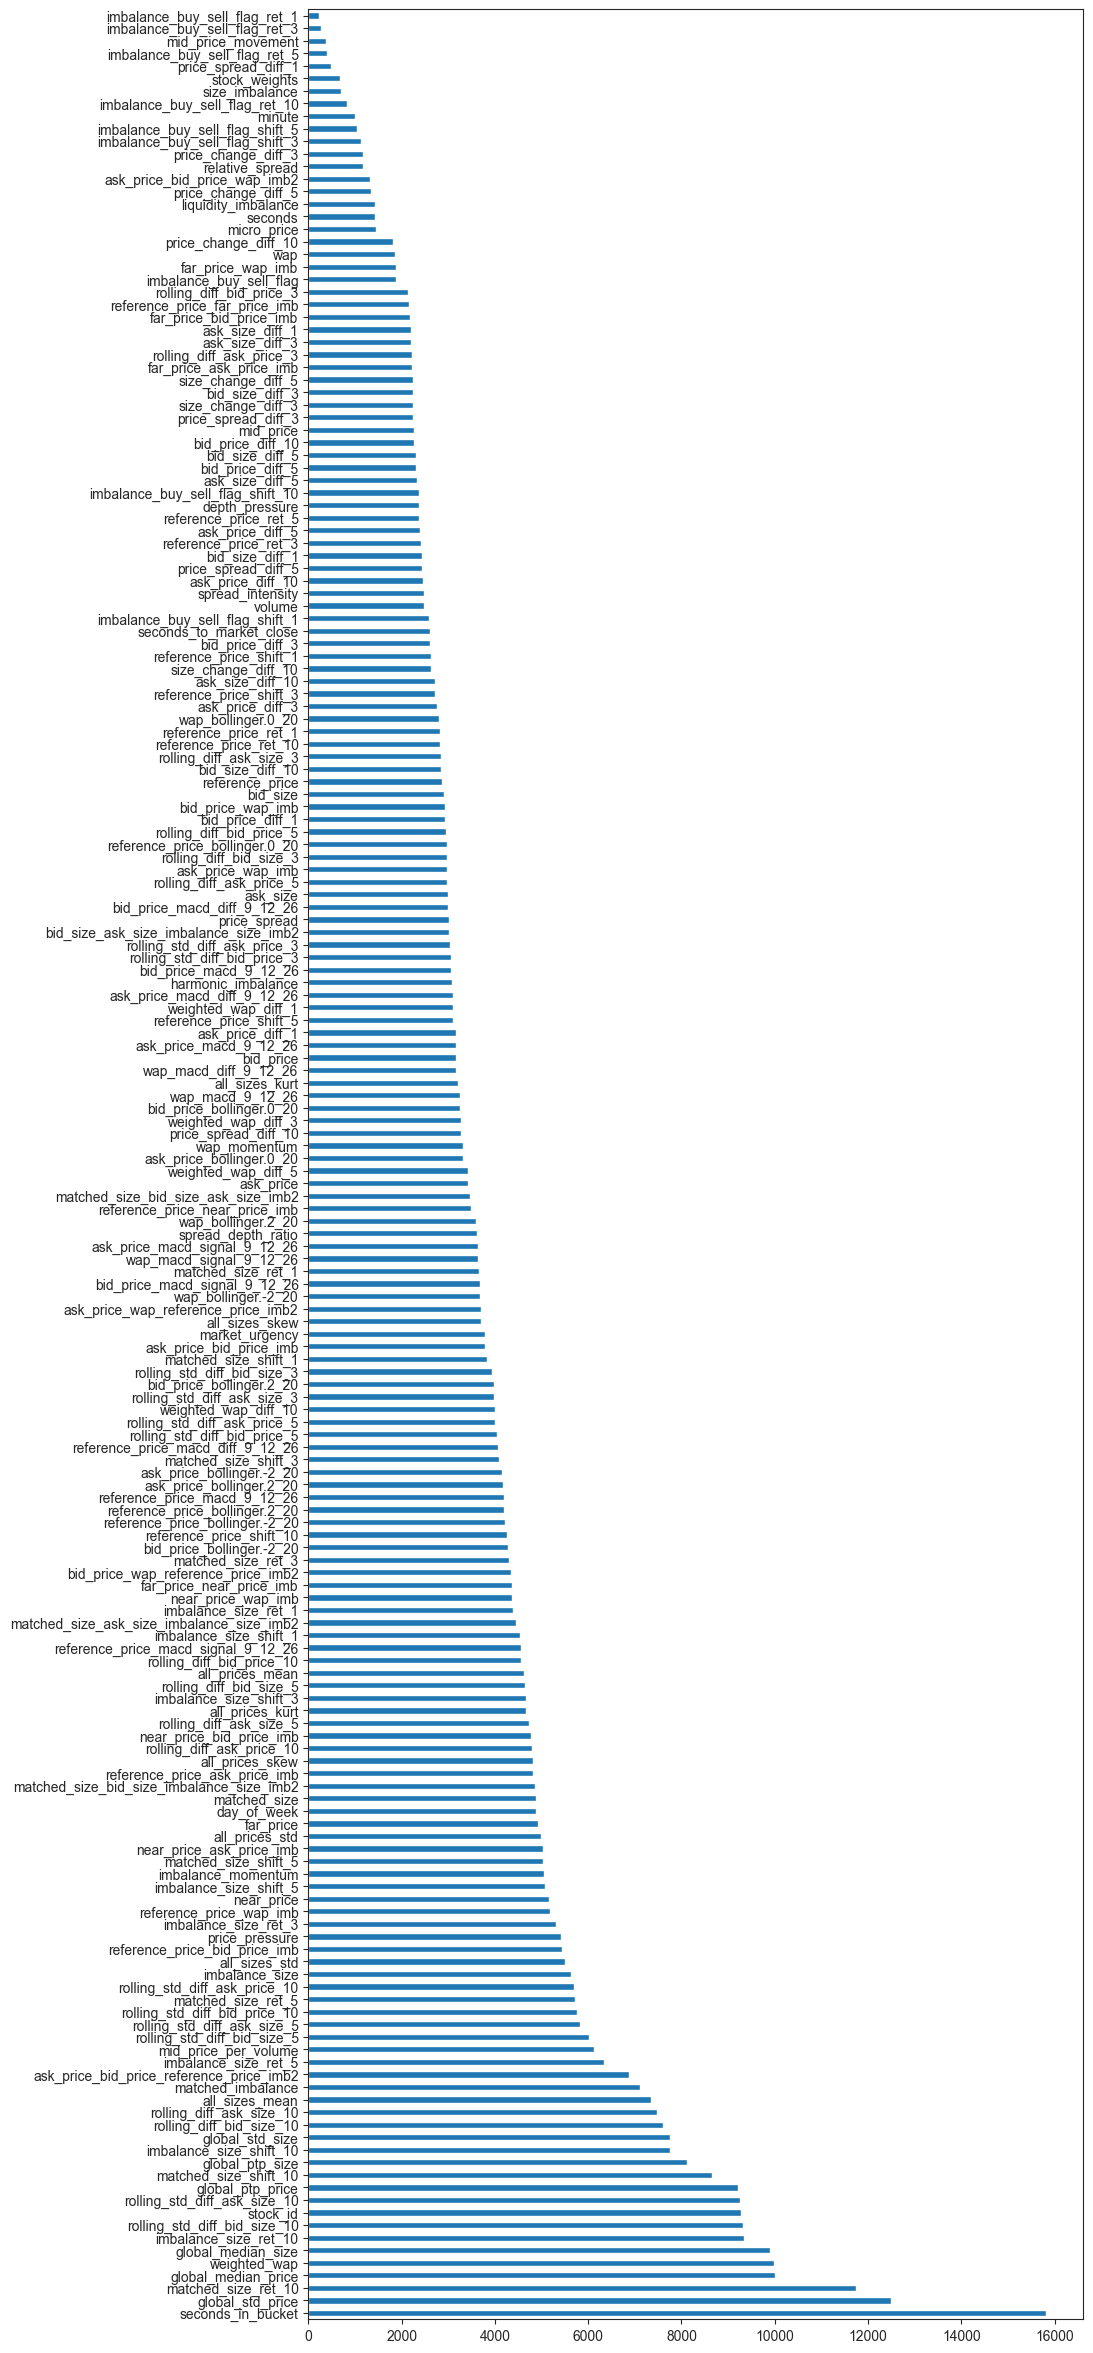

In [122]:
if (CFG.IS_TRAIN or CFG.IS_INFER) and CFG.PLOT:
    agreggated_feature_importances = (sum([model.feature_importance() \
                                           for model in lgbm_models])/len(lgbm_models)).astype(np.int32)

    df_feats = df.copy()
    df_feats = feature_engineering(df_feats.iloc[:100], stock_weights, stock_clusters, global_aggr)
    agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=df_feats.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 30))
    agreggated_feature_importances.plot(kind='barh')

In [113]:
#         cbt_model = cbt.CatBoostRegressor(objective='MAE', iterations=5000,bagging_temperature=0.5,
#                                 colsample_bylevel = 0.7,learning_rate = 0.065,
#                                 od_wait = 25,max_depth = 7,l2_leaf_reg = 1.5,
#                                 min_data_in_leaf = 1000,random_strength=0.65,
#                                 verbose=0,use_best_model=True,task_type='CPU')
#         cbt_model.fit(
#             df_fold_train[feature_columns],
#             df_fold_train_target,
#             eval_set=[(df_fold_valid[feature_columns], df_fold_valid_target)]
#         )
        
#         models_cbt.append(cbt_model)


### **Neural Network**
-------------------

In [114]:
"""
def create_mlp(num_continuous_features, num_categorical_features, embedding_dims, num_labels, hidden_units, dropout_rates, learning_rate,l2_strength=0.01):

    # Numerical variables input
    input_continuous = tf.keras.layers.Input(shape=(num_continuous_features,))

    # Categorical variables input
    input_categorical = [tf.keras.layers.Input(shape=(1,))
                         for _ in range(len(num_categorical_features))]

    # Embedding layer for categorical variables
    embeddings = [tf.keras.layers.Embedding(input_dim=num_categorical_features[i],
                                            output_dim=embedding_dims[i])(input_cat)
                  for i, input_cat in enumerate(input_categorical)]
    flat_embeddings = [tf.keras.layers.Flatten()(embed) for embed in embeddings]

    # concat numerical and categorical
    concat_input = tf.keras.layers.concatenate([input_continuous] + flat_embeddings)

    # MLP
    x = tf.keras.layers.BatchNormalization()(concat_input)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)

    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i],kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        #x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i+1])(x)

    #No activation
    out = tf.keras.layers.Dense(num_labels,kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)

    model = tf.keras.models.Model(inputs=[input_continuous] + input_categorical, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model
"""

"\ndef create_mlp(num_continuous_features, num_categorical_features, embedding_dims, num_labels, hidden_units, dropout_rates, learning_rate,l2_strength=0.01):\n\n    # Numerical variables input\n    input_continuous = tf.keras.layers.Input(shape=(num_continuous_features,))\n\n    # Categorical variables input\n    input_categorical = [tf.keras.layers.Input(shape=(1,))\n                         for _ in range(len(num_categorical_features))]\n\n    # Embedding layer for categorical variables\n    embeddings = [tf.keras.layers.Embedding(input_dim=num_categorical_features[i],\n                                            output_dim=embedding_dims[i])(input_cat)\n                  for i, input_cat in enumerate(input_categorical)]\n    flat_embeddings = [tf.keras.layers.Flatten()(embed) for embed in embeddings]\n\n    # concat numerical and categorical\n    concat_input = tf.keras.layers.concatenate([input_continuous] + flat_embeddings)\n\n    # MLP\n    x = tf.keras.layers.BatchNormalization

In [115]:
"""
if CFG.USE_NN:
    import numpy as np
    import gc
    import tensorflow as tf
    import tensorflow.keras.backend as K
    import tensorflow.keras.layers as layers
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
    
    df_train_feats = df_train_feats.groupby('stock_id').apply(lambda group: group.fillna(method='ffill')).fillna(0)
    
    categorical_features = ["stock_id"]
    numerical_features = [column for column in list(df_train_feats) if column not in categorical_features]
    num_categorical_features = [len(df_train_feats[col].unique()) for col in categorical_features]

    nn_models = []

    batch_size = 64
    hidden_units = [128,128]
    dropout_rates = [0.1,0.1,0.1]
    learning_rate = 1e-5
    embedding_dims = [20]

    directory = '/kaggle/working/NN_Models/'
    if not os.path.exists(directory):
        os.mkdir(directory)

    pred = np.zeros(len(df_train['target']))
    scores = []
    gkf = PurgedGroupTimeSeriesSplit(n_splits = 5, group_gap = 5)


    for fold, (tr, te) in enumerate(gkf.split(df_train_feats,df_train['target'],df_train['date_id'])):

        ckp_path = os.path.join(directory, f'nn_Fold_{fold+1}.h5')

        X_tr_continuous = df_train_feats.iloc[tr][numerical_features].values
        X_val_continuous = df_train_feats.iloc[te][numerical_features].values

        X_tr_categorical = df_train_feats.iloc[tr][categorical_features].values
        X_val_categorical = df_train_feats.iloc[te][categorical_features].values

        y_tr, y_val = df_train['target'].iloc[tr].values, df_train['target'].iloc[te].values

        print("X_train_numerical shape:",X_tr_continuous.shape)
        print("X_train_categorical shape:",X_tr_categorical.shape)
        print("Y_train shape:",y_tr.shape)
        print("X_test_numerical shape:",X_val_continuous.shape)
        print("X_test_categorical shape:",X_val_categorical.shape)
        print("Y_test shape:",y_val.shape)

        print(f"Creating Model - Fold{fold}")
        model = create_mlp(len(numerical_features), num_categorical_features, embedding_dims, 1, hidden_units, dropout_rates, learning_rate)

        rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=3, verbose=0, min_delta=1e-4, mode='min')
        ckp = ModelCheckpoint(ckp_path, monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
        es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=10, mode='min', restore_best_weights=True, verbose=0)

        print(f"Fitting Model - Fold{fold}")
        model.fit((X_tr_continuous,X_tr_categorical), y_tr,
                  validation_data=([X_val_continuous,X_val_categorical], y_val),
                  epochs=200, batch_size=batch_size,callbacks=[ckp,es,rlr])

        output = model.predict((X_val_continuous,X_val_categorical), batch_size=batch_size * 4)

        pred[te] += model.predict((X_val_continuous,X_val_categorical), batch_size=batch_size * 4).ravel()

        score = mean_absolute_error(y_val, pred[te])
        scores.append(score)
        print(f'Fold {fold} MAE:\t', score)

        # Finetune 3 epochs on validation set with small learning rate
        print(f"Finetuning Model - Fold{fold}")
        model = create_mlp(len(numerical_features), num_categorical_features, embedding_dims, 1, hidden_units, dropout_rates, learning_rate / 100)
        model.load_weights(ckp_path)
        model.fit((X_val_continuous,X_val_categorical), y_val, epochs=5, batch_size=batch_size, verbose=0)
        model.save_weights(ckp_path)
        nn_models.append(model)

        K.clear_session()
        del model
        gc.collect()

    print("Average NN CV Scores:",np.mean(scores))
"""

'\nif CFG.USE_NN:\n    import numpy as np\n    import gc\n    import tensorflow as tf\n    import tensorflow.keras.backend as K\n    import tensorflow.keras.layers as layers\n    from tensorflow.keras.regularizers import l2\n    from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping\n    \n    df_train_feats = df_train_feats.groupby(\'stock_id\').apply(lambda group: group.fillna(method=\'ffill\')).fillna(0)\n    \n    categorical_features = ["stock_id"]\n    numerical_features = [column for column in list(df_train_feats) if column not in categorical_features]\n    num_categorical_features = [len(df_train_feats[col].unique()) for col in categorical_features]\n\n    nn_models = []\n\n    batch_size = 64\n    hidden_units = [128,128]\n    dropout_rates = [0.1,0.1,0.1]\n    learning_rate = 1e-5\n    embedding_dims = [20]\n\n    directory = \'/kaggle/working/NN_Models/\'\n    if not os.path.exists(directory):\n        os.mkdir(directory)\n\n    pr

# **Submission**
------------------

In [116]:
if CFG.IS_INFER:
    # Online API
    if not CFG.LOCAL:

        import optiver2023
        optiver2023.make_env.func_dict['__called__'] = False # This enables running the API again if an error was produced

        env = optiver2023.make_env()
        iter_test = env.iter_test()

    # Local API
    else:
        from utils.public_timeseries_testing_util import MockApi
        import pandas as pd

        df = pd.read_csv(CFG.TEST_PATH)
        env = MockApi(df, start_date=478, end_date=480)
        iter_test = env.iter_test()


    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()
    
    feature_names = [col for col in df.columns if col not in ["target", "time_id"]]

    # Weights for each fold model
    lgb_model_weights = []
    if CFG.USE_LGB:
        lgb_model_weights = power_decay_weights(len(lgbm_models))


    models = lgbm_models 
    weights = lgb_model_weights
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test[feature_names]], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(["stock_id"]).tail(CFG.INFER_CACHE).sort_values(by=["date_id", "seconds_in_bucket", "stock_id"]).reset_index(drop=True)
        feat = feature_engineering(cache, stock_weights, stock_clusters, global_aggr)[-len(test):]
        feat = reduce_mem_usage(feat)

        # Generate predictions for each model and calculate the weighted average
        if CFG.USE_LGB:
            lgb_predictions = np.zeros(len(test))
            for model, weight in zip(models, weights):
                lgb_predictions += weight * model.predict(feat)

        predictions = lgb_predictions
        
        #Using mean predictions
        predictions = zero_mean(predictions)
        predictions = np.clip(predictions, y_min, y_max)
        predictions = np.nan_to_num(predictions)
        sample_prediction["target"] = predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, "qps:", np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")
